In [1]:
#Import packages

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from geopandas import GeoDataFrame
from shapely.geometry import Point
import geopandas as gpd


In [4]:
#Creemos una tabla con los poligonos de los radios censales de AMBA y que incluya la poblacion.
# Vamos a tener que hacer algunas maniobras...

# Cargar archivo
CABA_datos = gpd.read_file("../../datos/CABA/cabaxrdatos.shp")
# Seleccionar columnas deseadas
CABA_datos = CABA_datos[[u'PROV', u'DEPTO',u'LINK',u'VARONES',u'MUJERES',u'TOT_POB', u'HOGARES', u'VIV_PART', u'VIV_PART_H', u'geometry']]
# Tenemos que renombrarlas para que coincidan con las de la tabla de Buenos Aires (!!!)
CABA_datos.columns = [u'prov', u'depto',u'link',u'varon',u'mujer',u'totalpobl', u'hogares', u'viviendasp', u'viv_part_h', u'geometry']

# Cargar archivo
Buenos_Aires_datos = gpd.read_file("../../datos/Buenos Aires/Buenos_Aires_con_datos.shp")
# Le faltan columnas con codigo de provincia y departamento (!!!)
Buenos_Aires_datos['prov'] = Buenos_Aires_datos['link'].str[:2]
Buenos_Aires_datos['depto'] = Buenos_Aires_datos['link'].str[2:5]
Buenos_Aires_datos['dpto_link'] = Buenos_Aires_datos['link'].str[:5]
Buenos_Aires_datos = Buenos_Aires_datos[[u'prov', u'depto', u'link', u'varon', u'mujer', u'totalpobl',
       u'hogares', u'viviendasp', u'viv_part_h', u'geometry']]

In [5]:
CABA_polygon = CABA_datos.dissolve(by = 'prov')['geometry']
CABA_centroid = CABA_polygon.centroid.iloc[0]

In [6]:
partidos = Buenos_Aires_datos.dissolve(by = 'depto')[['geometry']]
partidos['distancia_CABA'] = [CABA_centroid.distance(m) for m in partidos.geometry]
partidos_GBA = partidos.sort_values(by = 'distancia_CABA')[:36].index
GBA_datos = Buenos_Aires_datos.loc[Buenos_Aires_datos.depto.isin(partidos_GBA)]
AMBA_datos = pd.concat([CABA_datos, GBA_datos])
AMBA_datos.to_csv('../../datos/AMBA_datos', index = False)

In [5]:
# deptos = gpd.read_file("datos/deptos/pxdptodatosok.shp")
# deptos['geometry'] = deptos['geometry'].to_crs(crs=pxlocdatos.crs)

In [6]:
edificios = pd.read_csv('datos/esc_sec_AMBA_geoloc_full.csv').dropna()

geometry = [Point(xy) for xy in zip(edificios.lng, edificios.lat)]
edificios.drop(['lng', 'lat'], axis=1, inplace=True)

edificios = GeoDataFrame(edificios, crs = {'init': u'epsg:4326'}, geometry=geometry)

edificios['geometry'] = edificios['geometry'].to_crs(crs=partidos.crs)

def getPointCoords(row, geom, coord_type):
    """Calculates coordinates ('x' or 'y') of a Point geometry"""
    if coord_type == 'x':
        return row[geom].x
    elif coord_type == 'y':
        return row[geom].y
    
edificios['x'] = edificios.apply(getPointCoords, geom='geometry', coord_type='x', axis=1)
edificios['y'] = edificios.apply(getPointCoords, geom='geometry', coord_type='y', axis=1)

/home/miglesia/anaconda2/lib/python2.7/site-packages/geopandas/plotting.py:255: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


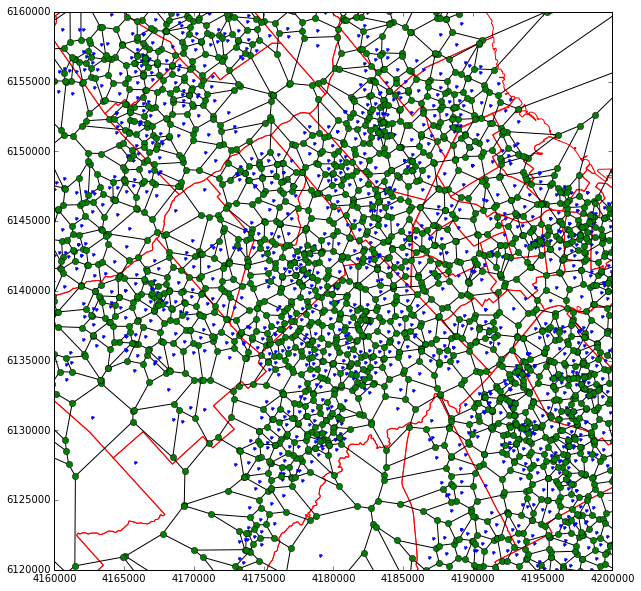

In [7]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import shapely.geometry
import shapely.ops

points = edificios[['x','y']].as_matrix()
vor = Voronoi(points)

f, ax = plt.subplots(1, figsize=(10, 10))
partidos['geometry'].plot(axes=ax, color = 'None', edgecolor = 'r')
CABA_datos.dissolve(by = 'depto')['geometry'].plot(axes=ax, color = 'None', edgecolor = 'r')
voronoi_plot_2d(vor, ax=ax)

plt.xlim(4160000, 4200000)
plt.ylim(6120000, 6160000)

plt.show()

lines = [
    shapely.geometry.LineString(vor.vertices[line])
    for line in vor.ridge_vertices]

p = []
for poly in shapely.ops.polygonize(lines):
    p += [poly]

voronoi = gpd.GeoDataFrame(p, columns = ['geometry'])



In [8]:
persona = gpd.GeoDataFrame(pd.read_csv('datos/PERSONA-P03.csv'))
persona.rename(columns={'radio': 'link', 'TOTAL': 'totalpobl'}, inplace=True)
persona['link'] = persona['link'].astype(str).str.zfill(9)
persona['persona_13_18'] = persona.iloc[:, 14:19].sum(axis = 1)

AMBA_datos_persona_13_18 = AMBA_datos.merge(persona[['link', 'persona_13_18']], on = 'link')

AMBA_datos_persona_13_18["area_km2"] = 10**-6 * AMBA_datos_persona_13_18['geometry'].area
AMBA_datos_persona_13_18['densidad'] = AMBA_datos_persona_13_18['persona_13_18'] / AMBA_datos_persona_13_18["area_km2"]

/home/miglesia/anaconda2/lib/python2.7/site-packages/geopandas/plotting.py:385: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


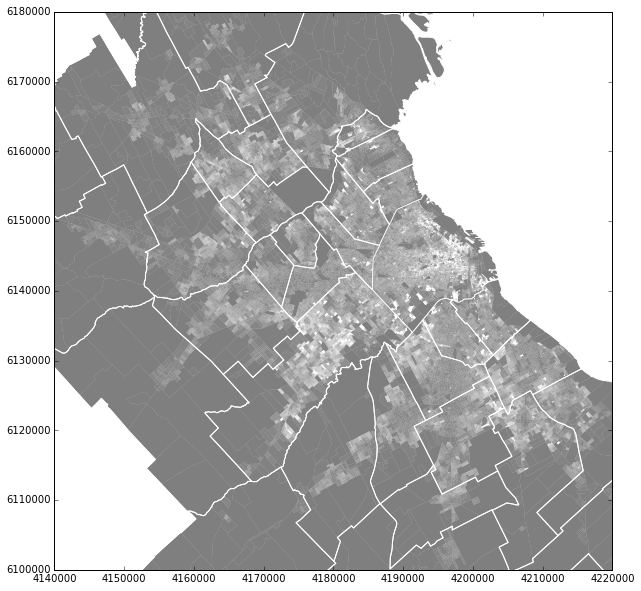

In [10]:
f, ax = plt.subplots(1, figsize=(10, 10))
AMBA_datos_persona_13_18.plot(axes = ax, column = 'densidad', cmap='gray', edgecolors = 'None', vmin = 0, vmax = 2300, alpha = 0.5)
partidos.plot(axes=ax, color = 'None', edgecolor = 'w')
plt.xlim(4140000, 4220000)
plt.ylim(6100000, 6180000)
plt.show()

In [11]:
#Guardamos los datasets procesados
voronoi.to_file('datos/voronoi_escuelas_secundarias_AMBA.shp')
AMBA_datos_persona_13_18.to_file('datos/AMBA_datos_persona_13_18.shp')
partidos.to_file('datos/partidos.shp')
CABA_datos.to_file('datos/CABA_datos.shp')